# Reverse-mode "Adjoint" Differentiation Through an ODE Solution
### Example 11.3
We are given a scalar ODE, with solution $u \in \mathcal{R}$, parameters $p \in \mathcal{R}^3$, and defined by:
$$
u_t = f(u, p, t) = p_1 + p_2 u + p_3 u^2 = \langle p, [1, u, u^2] \rangle
$$
The initial condition is $u_0 = 0$.

# Solve with Scipy

In [1]:
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
def f(u, p):
    return np.array([u_vec(u) @ p])

def u_vec(u):
    return np.concatenate([[1.], u, u**2])

p0 = np.array([1., 2., 3.]) * 0.1

u0 = np.array([0.0])

assert f(u0, p0).shape == u0.shape

In [3]:
def u(p, show=False):
    sol = solve_ivp(
        fun=lambda t, u: f(u, p),
        t_span=(0, 1),
        y0=u0,
        t_eval=np.linspace(0, 1)
    )
    if show:
        print(sol)
    return (sol.t, sol.y[0])

In [4]:
ts, us = u(p0, show=True)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.041e-02 ...  9.796e-01  1.000e+00]
        y: [[ 0.000e+00  2.045e-03 ...  1.094e-01  1.119e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 32
     njev: 0
      nlu: 0


# Plot

In [5]:
import matplotlib.pyplot as plt

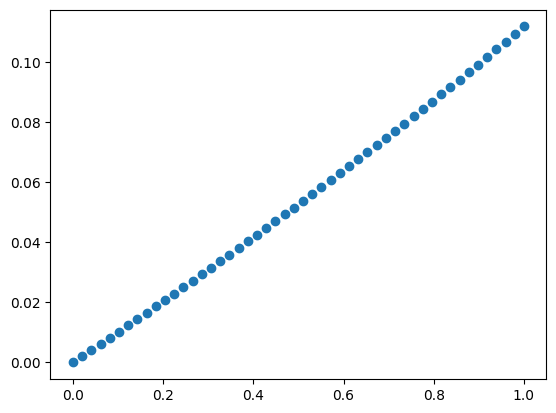

In [6]:
plt.scatter(ts, us)

# Evaluate Loss Functional
Given by $$G(p) = \int_0^T (u(p, t) - t^3)^2 dt $$

In [7]:
from scipy.integrate import trapezoid

def G(p, show=False):
    ts, us = u(p=p, show=show)
    gs = (us - ts**3)**2
    return trapezoid(gs, ts)

G(p0, show=True)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.041e-02 ...  9.796e-01  1.000e+00]
        y: [[ 0.000e+00  2.045e-03 ...  1.094e-01  1.119e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 32
     njev: 0
      nlu: 0


0.10309318796550947

# Find Gradient To Minimize Loss

We have no analytical form for the jacobian vector $\frac{\partial u}{\partial p}$, but we can find it using another ODE solve.

Since we know that $$u_t = f$$ we can derive w.r.t $p$, and exchange the derivative order.
$$
(u_p)_t = f_u u_p + f_p
$$
Where $u_p, f_p \in \mathcal{R}^3$, $f_u$ and is a scalar.

$$
\begin{align*}
f_u = p_2 + 2 p_3 u \\
f_p = [1, u, u^2]
\end{align*}
$$

We also know that $u_0 = 0$, so $(u_0)_p = 0$, too.

In [8]:
def f2(y, p):
    _, p2, p3 = p
    u = y[:1]
    u_p = y[1:]
    
    u_t = f(u=u, p=p)  # the ODE for u is solved at the same time.
    u_p_t = u_p * (p2 + 2*p3) + u_vec(u)
    return np.concatenate((u_t, u_p_t))
        

assert f2(np.ones(4), p=p0).shape == np.ones(4).shape

In [9]:
def u_p(p, show=False):
    sol = solve_ivp(
        fun=lambda t,y: f2(y,p),
        t_span=(0, 1),
        y0=np.zeros(4),
        t_eval=np.linspace(0, 1)
    )
    if show:
        print(sol)
    us = sol.y[0, :]
    u_ps = sol.y[1:, :]
    return sol.t, us, u_ps

In [10]:
ts, us, u_ps = u_p(p0, show=True)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.041e-02 ...  9.796e-01  1.000e+00]
        y: [[ 0.000e+00  2.045e-03 ...  1.094e-01  1.119e-01]
            [ 0.000e+00  2.058e-02 ...  1.487e+00  1.532e+00]
            [ 0.000e+00  2.097e-05 ...  6.778e-02  7.117e-02]
            [ 0.000e+00  2.854e-08 ...  4.506e-03  4.832e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 38
     njev: 0
      nlu: 0


Plot the 3 dimensions of $u_p$:

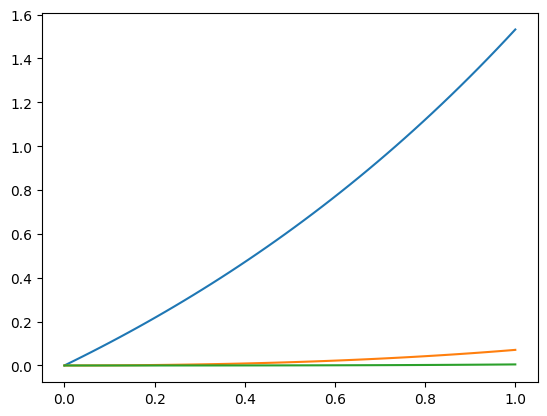

In [11]:
plt.plot(ts, u_ps.T)

Now the gradient is:
$$
\nabla_p G = 2 \int_0^T (u(p, t) - t^3) u_p^T dt
$$

In [12]:
def grad(p):
    ts, us, u_ps = u_p(p=p)
    ys = (us - ts**3) * u_ps
    return trapezoid(ys, ts)

grad(p=p0)

array([-0.23529337, -0.00946579, -0.00055955])

In [13]:
G(p0)

0.10309318796550947

In [14]:
G(p0 - grad(p0))

0.03844448988769641

# Optimize p

In [15]:
p = p0
for _ in range(50):
    p = p - 0.1 * grad(p)
    loss = G(p)
    print(loss)

0.09473186189350657
0.08716140384329202
0.08030948795343719
0.07411046938788712
0.06850469358217447
0.06343789518557541
0.058860672095156
0.054728022716710366
0.05099893675459746
0.047636031560086216
0.044605227461600144
0.04187545663070066
0.039418400956973784
0.03720825515748258
0.03522151196377252
0.033436766737209134
0.031834539279993204
0.0303971109560318
0.029108375518768027
0.02795370227750112
0.02691981042711065
0.025994653525474615
0.025167313234311078
0.0244279015476568
0.023767470821865876
0.02317793099535038
0.022651973448248035
0.022183001003274232
0.02176506361377428
0.02139279932153235
0.021061380098932842
0.02076646221805297
0.020504140813959598
0.020270908331612984
0.020063616565888513
0.019879442022718918
0.019715854346546876
0.01957058757538934
0.019441614000026607
0.01932712041825424
0.01922548658886396
0.0191352657031042
0.01905516670384811
0.018984038294593886
0.01892085449174306
0.01886470158437023
0.01881476637590244
0.01877032559178566
0.018730736346330858
0.01

In [16]:
ts, us = u(p)

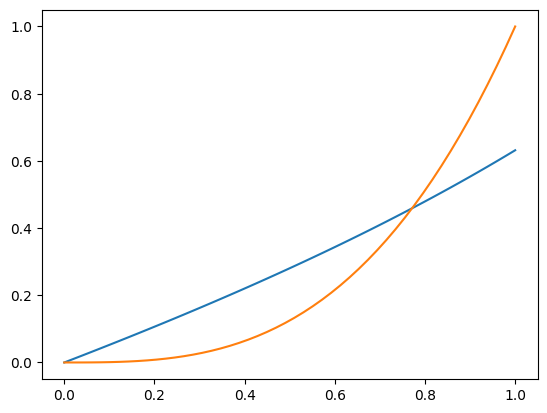

In [17]:
plt.plot(ts, us)
plt.plot(ts, ts**3)

The blue curve for $u(p, t)$ is the ODE solution for optimal $p^*$. The curve comes close to the $t^3$ curve. The crux is that the curve satisfies the ODE defined by $f$ in the beginning, and the initial condition $u_0=0$.